In this notebook, we present how we modified the open-source implementation of Shazam for the 1 vs 1 audio identification setting.

Usually, one would use `fingerprint.get_dict_for_file(filename)` to get the fingerprint of a file. Here, we want to visualize the constellations and the matching hashes, what involves more steps.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from audioId.shazam import fingerprint

In [2]:
AUDIO_DIR = "./../data"; track_name = "clip1.ogg"; obfuscated_track_name = "clip1_pitch.ogg"
filenames = [f"{AUDIO_DIR}/{tn}" for tn in [track_name, obfuscated_track_name]]
clip1_fp, clip1_obf_fp = [fingerprint.get_constellation_for_file(fn) for fn in filenames]

(2049, 645)
   local_maxima: 1180 of frequency & time pairs
(2049, 645)
   local_maxima: 1217 of frequency & time pairs


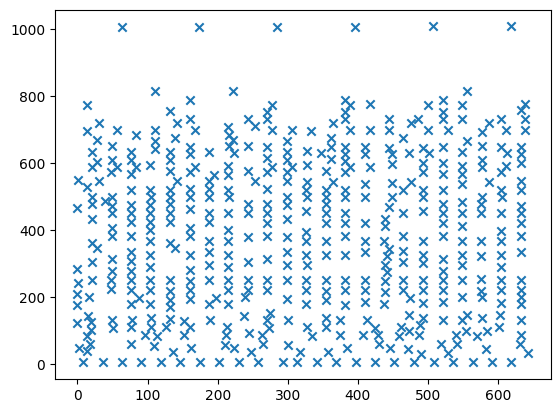

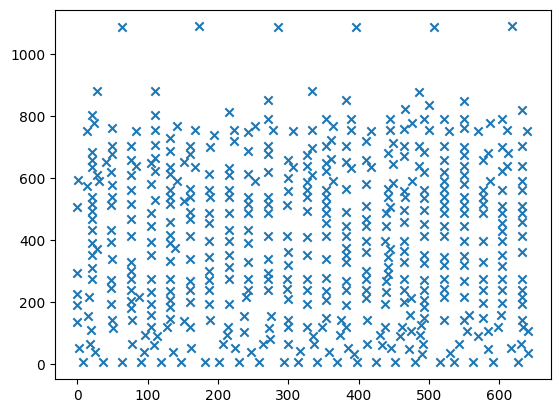

In [3]:
threshold = 130. # DEFAULT_AMP_MIN = 10
channel_num = 0
for fp in [clip1_fp, clip1_obf_fp]:
    plt.figure()
    channel = fp[channel_num]
    time_frequency_dots = np.array([[t_f_a[1], t_f_a[0]] for t_f_a in channel if t_f_a[2]>=threshold])
    x, y = time_frequency_dots.T
    plt.scatter(x, y, marker='x')
    plt.show()

In [4]:
def get_hashes_from_constellation(constellation):
    """From a list of maxima for each channel (returned by get_constellation_for_file),
    we obtain the hash list, except that the `value` contains more information. Normally, it's only the `t_1`,
    but here, it is ((t_1,f_1), (t_2,f_2), channel_num).
    """
    hashes = [list(fingerprint.generate_hashes(channel, extended_fingerprints=True)) for channel in constellation]
    hash_dict = {
        hash_key: (*value, channel_num)
        for channel_num, hashes_list in enumerate(hashes) for hash_key, value in hashes_list
    }
    return hash_dict

In [5]:
#clip1_hs, clip1_obf_hs = [fingerprint.get_dict_for_file(fn) for fn in filenames]
hash1, hash2 = [get_hashes_from_constellation(clip) for clip in [clip1_fp, clip1_obf_fp]]

In [6]:
hash_keys1, hash_keys2 = [set(hashes.keys()) for hashes in [hash1, hash2]]
common_hash_heys = hash_keys1.intersection(hash_keys2)

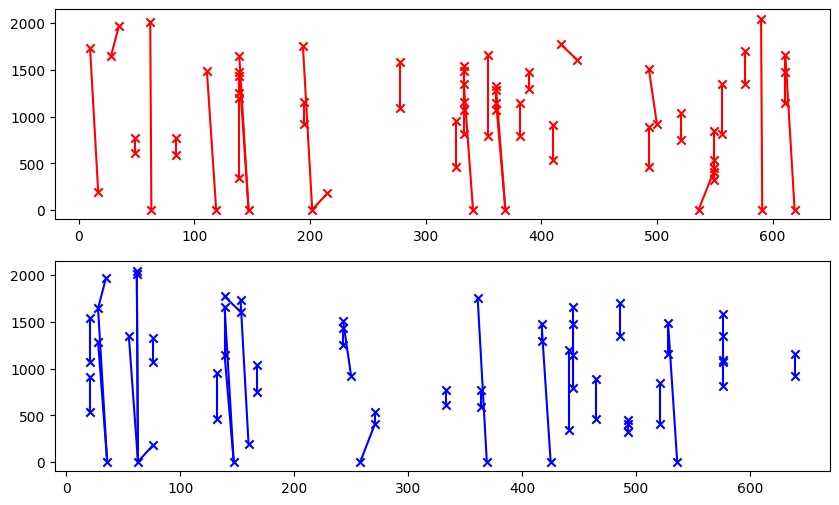

In [7]:
# Plot matching pairs
# Get points and edges to plot, for each song
fig, axes = plt.subplots(2, 1, figsize=(10, 6))
colors = ['red', 'blue']

for ind_song, hashes in enumerate([hash1, hash2]):
    points, edges = set(), []
    for common_key in common_hash_heys:
        tf1, tf2, channel = hashes[common_key]
        edges.append([tf1[0:2], tf2[0:2]])
        points.update([tf1, tf2])
    edges = np.array(edges)
    points = np.array(list(points))

    axes[ind_song].plot(edges[:,:,0].T, edges[:,:,1].T, c=colors[ind_song])
    axes[ind_song].scatter(points[:,0], points[:,1], c=colors[ind_song], marker='x')
plt.show()

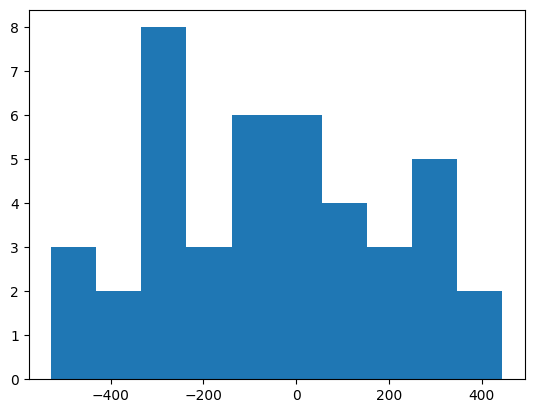

In [9]:
# Figure 2B - histograms of matching times.
times = []
for ind_song, hashes in enumerate([hash1, hash2]):
    times_for_song = []
    for common_key in common_hash_heys:
        tf1, tf2, channel = hashes[common_key]
        times_for_song.append(tf1[0])
    times.append(times_for_song)
times = np.array(times)
time_differences = times[1] - times[0]
plt.figure()
plt.hist(time_differences)
plt.show()

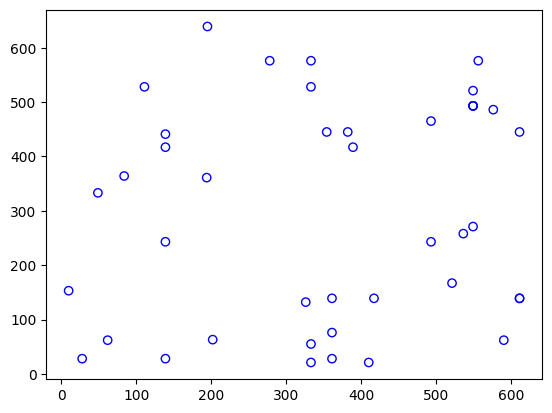

In [10]:
plt.figure()
plt.scatter(times[0], times[1], marker='o', edgecolors='b', facecolors='none')
plt.show()